# import and visualize oil data

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

In [8]:
oildata = pd.read_csv('oil.csv',sep=',',header=0,index_col=0)
oildata.head()

,OilProduction
1965,111.009135
1966,130.828434
1967,141.287088
1968,154.227775
1969,162.740865


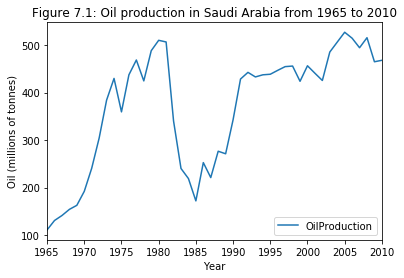

In [27]:
plt.figure();
axes = oildata.plot();
axes.set_xlabel('Year')
axes.set_ylabel('Oil (millions of tonnes)')
axes.set_title('Figure 7.1: Oil production in Saudi Arabia from 1965 to 2010');

# Reproduce plot in Figure 7.2